![alt text](https://static1.squarespace.com/static/5ea57eb1c6398826cb20f779/t/5ea5875b36c5d45a8f64f9f3/1595005115947/?format=180w 'DNAstack logo')


For demonstration purposes only

# Statistical Analysis Using COVID Cloud and Azure

In this notebook we will be demonstrating how to do statistical analysis with Azure Notebooks using SARS-CoV-2 variant data from COVID Cloud.

The statistical analysis in this notebook will include:

1. Basic Summary Statistics using `pandas`
3. Hypothesis Testing using `scipy`
2. Phylogenetic Trees using `scipy`

Before you begin, you must download the libraries required for this analysis, and restart the notebook if necessary. In order to download the necessary libraries, make sure the requirements.txt file is included in the directory.

In [2]:
%%bash
python3 -m pip install --no-cache-dir \
dnastack-client-library \
"plotly>=4.12.0" \
"matplotlib>=3.3.2" \
"seaborn>=0.11.1" \
jupyter \
"notebook>=5.3" \
"ipywidgets>=7.5" \
"numpy>=1.19.2" \
"scipy>=1.5.2" \
"scikit-learn>=0.23.2" \
"statsmodels>=0.12.1" \
"pandas"

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3 -m pip install --upgrade pip' command.


The next and most important step is to use the `search_python_client` library to download COVID variant data. 

There are 2 main tables we want to use for the analysis:
- `variant` table
- `meta` table 

The following downloads should be complete in one to two minutes.

In [6]:
from dnastack import PublisherClient
import pandas as pd


#### Create the client
dataconnect_url = 'https://collection-service.publisher.dnastack.com/collection/library/search/'
publisher_client = PublisherClient(dataconnect_url=dataconnect_url)

#### Download metadata
print('Fetching metadata from DNAstack…')
query = "SELECT * FROM covid.cloud.sequences WHERE collection_date < date('2020-09-01')"
meta_df = pd.DataFrame(publisher_client.dataconnect.query(query))
print("Metadata:")
print(meta_df)

#### Download variant data
print('Fetching variants from DNAstack…')
query = """
SELECT v.*
FROM covid.cloud.variants AS v JOIN covid.cloud.sequences AS s ON s.accession = sequence_accession
WHERE s.collection_date < date('2020-09-01')
"""
variant_df = pd.DataFrame(publisher_client.dataconnect.query(query))
print("Variant Data:")
print(variant_df)

Fetching metadata from DNAstack…
Metadata:
       accession  sequence_length          host      isolation_source  \
0       MT385456          29862.0  Homo sapiens                  None   
1       MT385485          29835.0  Homo sapiens                  None   
2       MT438736          29862.0  Homo sapiens                  None   
3       MT385434          29893.0  Homo sapiens                  None   
4       MT385480          29836.0  Homo sapiens                  None   
...          ...              ...           ...                   ...   
153954  MN975262          29891.0  Homo sapiens  lung, oronasopharynx   
153955  MN975267            107.0  Homo sapiens        oronasopharynx   
153956  MW565821          29875.0  Homo sapiens                  None   
153957  MW565822          29693.0  Homo sapiens                  None   
153958  MW565823          29876.0  Homo sapiens                  None   

                  location collection_date release_date data_source  \
0        

Here is a quick look at each table!

In [12]:
meta_df.head(3)

,accession,sequence_length,host,isolation_source,location,collection_date,release_date,data_source,nucleotide_completeness,sample_accession,reporting_authors,publications,lineage,lineage_confidence
0,MT385456,29862.0,Homo sapiens,None,USA: CA,2020-03-01,2020-04-27,GenBank,complete,None,None,None,A.1,1.0
1,MT385485,29835.0,Homo sapiens,None,USA: CA,2020-04-01,2020-04-27,GenBank,complete,None,None,None,A.1,1.0
2,MT438736,29862.0,Homo sapiens,None,USA: CA,2020-04-01,2020-05-07,GenBank,complete,None,None,None,B.1.14,1.0


In [13]:
variant_df.head(3)

,start_position,end_position,reference_bases,alternate_bases,sequence_accession
0,362,363,A,G,MT956769
1,4623,4624,A,G,MT973446
2,26161,26162,A,G,MT970884


## 1. Basic Summary Statistics using Pandas

In this example, you will be investigating the number of samples by variant.

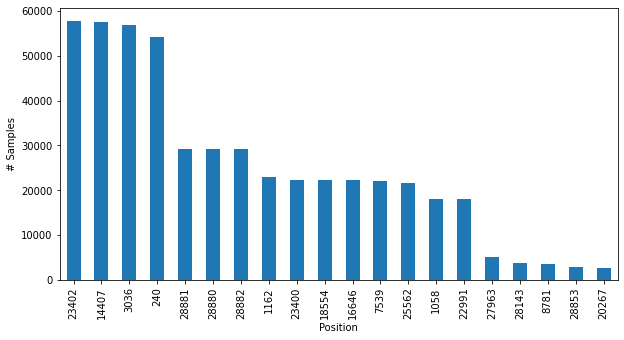

In [7]:
import pandas as pd
import matplotlib

#  Plot the number of variants there are at each position for the top 20 most frequent variants
_ = (
    variant_df.start_position
              .value_counts()
              .head(20)
              .plot.bar(figsize=(10, 5),
                        xlabel='Position',
                        ylabel='# Samples')
)

We can see that the 23402 variant is the most prevalent of all variants. Variant 23402 responds to the D614G mutation.

## 2. Hypothesis Testing using SciPy

In this example, you will be investigating the difference between the proportion of positive and negative samples of the D614 variant in March and August.

In [8]:
from scipy.stats import chi2_contingency

# Get sample accessions for samples that have the D614G mutation
accessions = variant_df[variant_df.start_position == 23402].sequence_accession

# Filter by months { collection_date.contains(2020-03), collection_date.contains(2020-08) } 
march_meta_df = meta_df[meta_df.collection_date.str.contains('2020-03', na=False)] 
august_meta_df = meta_df[meta_df.collection_date.str.contains('2020-08', na=False)]

# Filter meta table by sample accessions to obtain contingency data
h0_n = march_meta_df[~(march_meta_df.accession.isin(accessions))].shape[0]
h0_p = march_meta_df[(march_meta_df.accession.isin(accessions))].shape[0]
h1_n = august_meta_df[~(august_meta_df.accession.isin(accessions))].shape[0]
h1_p = august_meta_df[(august_meta_df.accession.isin(accessions))].shape[0]

# Chi2 test
chi_results = chi2_contingency([[h0_n, h0_p],
                                [h1_n, h1_p]])
print('χ2:', chi_results[0])
print('p:', chi_results[1])

χ2: 4958.983362600678
p: 0.0


As the data shows, there is a significant difference between the proportion of D614 positive samples to negative samples in March and August!

## 3. Phylogenetic Trees using SciPy

In this example, we will be creating a phylogenetic tree for the 20 most common variants, in order to investigate which variants most commonly occur together.

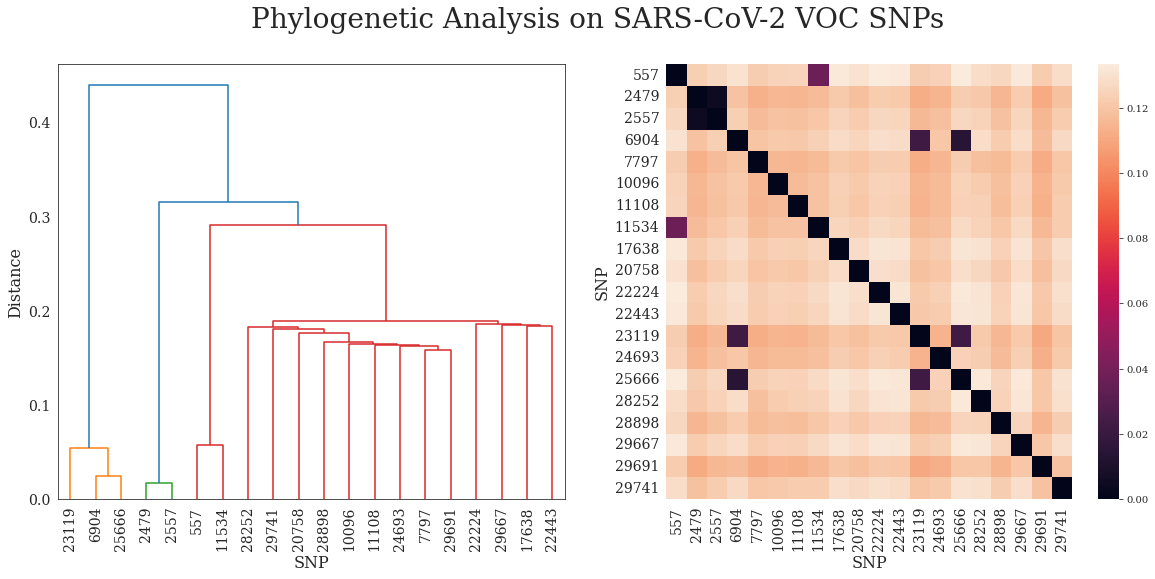

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.simplefilter('ignore')

from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist, squareform

# Filtering to 20 variants
v_df = variant_df[variant_df.start_position.isin(variant_df.start_position.value_counts().iloc[100: 120].index)]

# Distance calculations
ct           = pd.crosstab(v_df.sequence_accession, v_df.start_position)
corr         = squareform(pdist(ct.T, metric='hamming'))
corr_linkage = hierarchy.ward(corr)

# Plot misc
sns.set_style("white")
plt.rcParams["font.family"] = "serif"

# Figure
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
fig.set_facecolor('white')
ax1, ax2 = ax

# Plot
_ = hierarchy.dendrogram(corr_linkage, labels=ct.columns, leaf_rotation=90, ax=ax1)
sns.heatmap(pd.DataFrame(corr, columns=ct.columns, index=ct.columns), ax=ax2)

# Labels
_ = fig.suptitle('Phylogenetic Analysis on SARS-CoV-2 VOC SNPs', fontsize=28)
_ = ax1.set_xlabel('SNP', fontsize=16)
_ = ax1.set_ylabel('Distance', fontsize=16)
_ = ax2.set_xlabel('SNP', fontsize=16)
_ = ax2.set_ylabel('SNP', fontsize=16)

# Ticks
_ = ax1.tick_params(axis='both', labelsize=14)
_ = ax2.tick_params(axis='both', labelsize=14)

We can see distinct clusters from this analysis! This means that certain variants (e.g. 1384 and 3241) are more likely to be inherited together.